# CS224W: Learning DAG-Based Job Scheduling with Graph Neural Networks and Reinforcement Learning


## Set Up

In [ ]:
!pip install torch-geometric
!pip install ogb
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from typing import Dict, List, Tuple, Optional, Set
from google.colab import drive
import math, random, heapq
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [ ]:
drive.mount('/content/drive')
os.chdir("/content/drive/Shareddrives/CS224W")

Mounted at /content/drive


## Define Data Models

In [ ]:
@dataclass
class Machine:
    machine_id: int
    cpu_capacity: float = 96.0
    mem_capacity: float = 100.0
    cpu_used: float = 0.0
    mem_used: float = 0.0

    def can_place(self, cpu_req: float, mem_req: float) -> bool:
        return (self.cpu_used + cpu_req <= self.cpu_capacity + 1e-9) and (self.mem_used + mem_req <= self.mem_capacity + 1e-9)

    def place(self, cpu_req: float, mem_req: float):
        self.cpu_used += cpu_req
        self.mem_used += mem_req

    def release(self, cpu_req: float, mem_req: float):
        self.cpu_used -= cpu_req
        self.mem_used -= mem_req
        if self.cpu_used < 0: self.cpu_used = 0.0
        if self.mem_used < 0: self.mem_used = 0.0

In [ ]:
class Task:
    def __init__(self, task_name, num_instances, task_type: int, cpu, mem, instance_running_time: list, parents=None):
        self.task_name = task_name
        self.num_instances = num_instances
        self.task_type = task_type
        self.cpu = cpu
        self.mem = mem
        self.parents = parents or []
        self.remaining_instances = num_instances
        self.instance_running_time = instance_running_time # Not visible to schedulers
        self.completed = False

    def task_next_runtime(self) -> Optional[float]:
        idx_done = self.num_instances - self.remaining_instances
        if idx_done < len(self.instance_running_time):
             return float(self.instance_running_time[idx_done])
        return None

    def __repr__(self):
        return (f"Task({self.task_name}, num={self.num_instances}, task_type={self.task_type},"
                f"cpu={self.cpu}, mem={self.mem}, parents={self.parents})")

In [ ]:
class Job:
    def __init__(self, job_name, arrival_time, tasks: list):
        self.job_name = job_name
        self.arrival_time = arrival_time
        self.tasks = tasks
        self.completed_tasks = set()
        self.start_time = None
        self.end_time = None

    def index_job(self) -> Dict[str, Task]:
        return {t.task_name: t for t in self.tasks}

    def job_ready_tasks(self, name_to_task: Dict[str, Task]) -> List[Task]:
        ready = []
        for t in self.tasks:
            if t.completed:
                continue
            if all(name_to_task[p].completed for p in t.parents):
                if t.remaining_instances > 0:
                    ready.append(t)
        return ready

    def __repr__(self):
        return f"Job({self.job_name}, {len(self.tasks)} tasks, arrival={self.arrival_time})"

## Load and Process Data

In [ ]:
# ----------------------------------------------------------------------
# CSV schemas
# ----------------------------------------------------------------------
batch_task_columns = [
    "task_name", "instance_num", "job_name", "task_type", "status",
    "start_time", "end_time", "plan_cpu", "plan_mem"
]

batch_instance_columns = [
    "instance_name", "task_name", "job_name", "task_type", "status",
    "start_time", "end_time", "machine_id", "seq_no", "total_seq_no",
    "cpu_avg", "cpu_max", "mem_avg", "mem_max"
]

# ----------------------------------------------------------------------
# Helper functions
# ----------------------------------------------------------------------
def clean_dataframe(df, numeric_cols):
    """
    Remove rows that contain invalid strings in numeric columns like 'instance_num' or 'plan_cpu'.
    """
    for col in numeric_cols:
        df = df[pd.to_numeric(df[col], errors='coerce').notna()]
    return df.reset_index(drop=True)


def infer_parents(task_name, all_task_names_in_job):
    """
    Infer parent task names for the given task_name.
    If no numeric IDs are found, return empty list (independent task).
    """
    parts = task_name.split("_")

    # Extract first numeric ID
    nums_in_first = re.findall(r"\d+", parts[0])
    if not nums_in_first:
        return []  # no numeric ID → independent task

    current_id = int(nums_in_first[0])

    # Extract remaining numeric IDs as parent IDs
    parent_ids = []
    for p in parts[1:]:
        nums = re.findall(r"\d+", p)
        parent_ids.extend([int(n) for n in nums])

    parents = []
    for pid in parent_ids:
        # find task in job with matching numeric ID
        for t in all_task_names_in_job:
            nums = re.findall(r"\d+", t)
            if nums and int(nums[0]) == pid:
                parents.append(t)
                break
    return parents

In [ ]:

# ----------------------------------------------------------------------
# Core builder
# ----------------------------------------------------------------------
def build_jobs_and_tasks(
    task_csv,
    instance_csv,
    lambda_rate=0.05,        # jobs per unit time (λ > 0)
    seed=None,               # for reproducibility
    integer_time=True,       # round to integer timesteps if your simulator expects ints
    time_scale=1.0           # multiply arrival times by this factor (e.g., convert units)
):
    if lambda_rate <= 0:
        raise ValueError("lambda_rate must be > 0")

    # Read CSVs (no headers) and assign column names manually
    df_task = pd.read_csv(task_csv, header=None, names=batch_task_columns)
    df_instance = pd.read_csv(instance_csv, header=None, names=batch_instance_columns)

    # Clean bad rows (where numeric fields contain text like 'instance_num')
    df_task = clean_dataframe(df_task, ["instance_num", "plan_cpu", "plan_mem"])
    df_instance = clean_dataframe(df_instance, ["start_time", "end_time", "cpu_avg", "mem_avg"])

    # --------- Poisson arrivals (generate once for all jobs) ----------
    job_names = sorted(df_task["job_name"].dropna().unique().tolist())
    n_jobs = len(job_names)

    rng = np.random.default_rng(seed)
    inter_arrivals = rng.exponential(scale=1.0 / lambda_rate, size=n_jobs)  # Exponential(λ)
    arrival_times = np.cumsum(inter_arrivals) * float(time_scale)
    if integer_time:
        arrival_times = np.rint(arrival_times).astype(int)

    job_to_arrival = {jn: at for jn, at in zip(job_names, arrival_times)}
    # ---------------------------------------------------------------

    jobs = {}
    instance_groups = df_instance.groupby(["job_name", "task_name"], dropna=False)

    for job_name, job_tasks in df_task.groupby("job_name"):
        task_objects = []

        # Get all task names in the job
        all_task_names = job_tasks["task_name"].astype(str).tolist()

        for _, row in job_tasks.iterrows():
            task_name = str(row["task_name"]).strip()
            cpu = float(row["plan_cpu"])
            mem = float(row["plan_mem"])
            task_type = int(row["task_type"])

            # Get instances for this (job, task)
            if (job_name, task_name) in instance_groups.groups:
                inst = instance_groups.get_group((job_name, task_name))
                actual_instances = len(inst)
                # ensure numeric; clean_dataframe should already do this
                instance_running_time = (inst["end_time"].astype(float) - inst["start_time"].astype(float)).tolist()
            else:
                actual_instances = 0
                instance_running_time = []

            parents = infer_parents(task_name, all_task_names)

            task_obj = Task(
                task_name=task_name,
                num_instances=actual_instances,
                task_type=task_type,
                cpu=cpu,
                mem=mem,
                instance_running_time=instance_running_time,
                parents=parents
            )
            task_objects.append(task_obj)

        # Poisson-process arrival time
        arrival_time = job_to_arrival[job_name]
        jobs[job_name] = Job(job_name, arrival_time, task_objects)

    return jobs

In [ ]:
# Construct graphs
jobs = build_jobs_and_tasks("data_clean/batch_task.csv", "data_clean/batch_instance.csv", lambda_rate=0.008)

## Implement Cluster Simulator

In [ ]:
class ClusterSim:
    """
    Event-driven cluster simulator with cluster state tracking for RL training.
    Supports all schedulers (FIFO, SJF, GNN, RL-GNN).
    """
    def __init__(self, machines: List[Machine], scheduler: BaseScheduler):
        self.machines = machines
        self.scheduler = scheduler

        self.total_cpu = 0.0   # cluster-wide CPU capacity
        self.total_mem = 0.0   # cluster-wide MEM capacity

        for m in machines:
            self.total_cpu += m.cpu_capacity
            self.total_mem += m.mem_capacity

        self.used_cpu = 0.0
        self.used_mem = 0.0

        self.jobs_pending: Dict[str, Job] = {}
        self.jobs_active: Dict[str, Job] = {}
        self.jobs_finished: Dict[str, Job] = {}

        self.name_to_task: Dict[str, Dict[str, Task]] = {}
        self.job_graphs: Dict[str, Data] = {}

        self.arrival_heap: List[Tuple[float, str]] = []
        self.running_heap: List[Tuple[float, str, str, int, float, float]] = []

        self.now: float = 0.0
        self.job_completion_time: Dict[str, float] = {}

        # RL-specific tracking (optional, for future use)
        self.scheduling_steps = []  # Track (time, action, reward) for RL

        # NEW: time-series metrics for visualization
        self.metrics_history: List[Dict[str, float]] = []  # each entry: {"time", "num_active_jobs", "used_cpu", "used_mem"}

    def add_jobs(self, jobs: Dict[str, Job]):
        self.jobs_pending = dict(jobs)
        self.arrival_heap.clear()
        for jid, job in jobs.items():
            heapq.heappush(self.arrival_heap, (job.arrival_time, jid))
            self.name_to_task[jid] = job.index_job()
        # Build graphs - use unified function for all schedulers
        self.job_graphs = build_job_graphs_with_cluster_state(
            jobs,
            available_cpu=self.total_cpu,
            available_mem=self.total_mem,
            total_cpu=self.total_cpu,
            total_mem=self.total_mem
        )

    def _next_event_time(self) -> float:
        candidates = []
        if self.arrival_heap:
            candidates.append(self.arrival_heap[0][0])
        if self.running_heap:
            candidates.append(self.running_heap[0][0])
        return min(candidates) if candidates else float('inf')

    def _pop_arrivals(self, t: float):
        out = []
        while self.arrival_heap and abs(self.arrival_heap[0][0] - t) < 1e-9:
            _, jid = heapq.heappop(self.arrival_heap); out.append(jid)
        return out

    def _pop_finishes(self, t: float):
        out = []
        while self.running_heap and abs(self.running_heap[0][0] - t) < 1e-9:
            out.append(heapq.heappop(self.running_heap))
        return out

    def _ready_pairs(self):
        pairs = []
        for jid, job in self.jobs_active.items():
            for t in job.job_ready_tasks(self.name_to_task[jid]):
               pairs.append((jid, t.task_name))
        return pairs

    def _try_place(self, jid: str, tid: str):
        job = self.jobs_active.get(jid)
        if job is None:
            return False

        t = self.name_to_task[jid][tid]
        rt = t.task_next_runtime()
        if rt is None or t.remaining_instances <= 0:
            return False

        # ensure inflight counter exists
        if not hasattr(t, "inflight"):
            t.inflight = 0

        # ----- GLOBAL RESOURCE CHECK (cluster-level) -----
        if self.used_cpu + t.cpu <= self.total_cpu + 1e-9 and \
            self.used_mem + t.mem <= self.total_mem + 1e-9:

            # Reserve cluster resources (no machine selection)
            self.used_cpu += t.cpu
            self.used_mem += t.mem

            finish = self.now + rt
            # mid=None because machine is now meaningless
            heapq.heappush(self.running_heap, (finish, jid, tid, None, t.cpu, t.mem))

            t.remaining_instances -= 1
            t.inflight += 1
            if job.start_time is None:
                job.start_time = self.now

            return True
        return False

    def _maybe_finish_job(self, jid: str):
        job = self.jobs_active.get(jid)
        if job is None:
            return
        if all(t.completed for t in job.tasks):
            job.end_time = self.now
            self.job_completion_time[jid] = job.end_time - job.arrival_time
            self.jobs_finished[jid] = job
            del self.jobs_active[jid]

    def step(self):
        """Event-driven step with cluster state updates."""
        t_next = self._next_event_time()
        if t_next == float('inf'):
            return False

        # For RL: remember how many trajectory entries existed before this event
        ### NEW: record index range for this scheduling event
        event_start_idx = len(getattr(self.scheduler, "trajectory", [])) if hasattr(self.scheduler, "trajectory") else 0

        # Compute dt just for logging / reward later
        ### NEW: dt is useful for Decima reward; we won't use it here directly
        dt = t_next - self.now
        if dt < 0:
            dt = 0.0

        self.now = t_next

        # Update cluster state in graphs before scheduling (for all schedulers)
        available_cpu = self.total_cpu - self.used_cpu
        available_mem = self.total_mem - self.used_mem

        for jid in self.jobs_active.keys():
            if jid in self.job_graphs:
                data = self.job_graphs[jid]
                if data.x.size(1) >= 9:  # Has cluster state features
                    cpu_ratio = available_cpu / self.total_cpu if self.total_cpu > 0 else 1.0
                    mem_ratio = available_mem / self.total_mem if self.total_mem > 0 else 1.0
                    data.x[:, -2] = cpu_ratio
                    data.x[:, -1] = mem_ratio

        # arrivals
        for jid in self._pop_arrivals(self.now):
            job = self.jobs_pending.pop(jid, None)
            if job:
                self.jobs_active[jid] = job

        # finishes
        for finish, jid, tid, mid, cpu, mem in self._pop_finishes(self.now):
            # Release back to cluster pool
            self.used_cpu -= cpu
            self.used_mem -= mem

            job = self.jobs_active.get(jid)
            if job:
                t = self.name_to_task[jid][tid]
                if not hasattr(t, "inflight"):
                    t.inflight = 0
                t.inflight = max(0, t.inflight - 1)

                # Mark completed only when last instance is actually done
                if t.remaining_instances == 0 and t.inflight == 0:
                    t.completed = True
                job.completed_tasks.add(tid)

                self._maybe_finish_job(jid)

        # scheduling loop
        while True:
            ready = self._ready_pairs()
            if not ready:
                break

            order = self.scheduler.pick(self.now, ready, self)
            if not order:
                break

            placed = False

            for (jid, tid, par) in order:
                # Ensure at least 1
                par = max(1, int(par))

                # Try up to `par` instances of this (job, task)
                job = self.jobs_active.get(jid)
                if job is None:
                    continue
                t = self.name_to_task[jid][tid]

                # Hard upper bound: cannot exceed remaining_instances
                max_possible = t.remaining_instances
                if max_possible <= 0:
                    continue

                par = min(par, max_possible)

                for _ in range(par):
                    if self._try_place(jid, tid):
                        placed = True
                    else:
                        # Can't place more (no capacity or no remaining instances)
                        break

            if not placed:
                # No instance of any candidate could be placed in this round
                break

        ### NEW: annotate RL trajectory entries from this event with time & num_jobs_in_system
        if hasattr(self.scheduler, "trajectory") and getattr(self.scheduler, "training", False):
            traj = self.scheduler.trajectory
            num_jobs_in_system = len(self.jobs_active)
            for i in range(event_start_idx, len(traj)):
                traj[i]["time"] = self.now
                traj[i]["num_jobs_in_system"] = num_jobs_in_system

        # NEW: record metrics for visualization
        num_active_jobs = len(self.jobs_active)
        self.metrics_history.append({
            "time": self.now,
            "num_active_jobs": float(num_active_jobs),
            "used_cpu": float(self.used_cpu),
            "used_mem": float(self.used_mem),
        })

        return True

    def run(self):
        while self.step():
            pass
        return self.job_completion_time

In [ ]:
def build_machines(M: int = 100, cpu: float = 96.0, mem: float = 100.0) -> List[Machine]:
    return [Machine(machine_id=i, cpu_capacity=cpu, mem_capacity=mem) for i in range(M)]

In [ ]:
def build_job_graphs_with_cluster_state(
    jobs: Dict[str, Job],
    available_cpu: float = None,
    available_mem: float = None,
    total_cpu: float = None,
    total_mem: float = None
) -> Dict[str, Data]:
    """
    Build job graphs with cluster state features (available CPU/memory).
    If cluster state is None, uses default values (normalized to 1.0).
    This is the unified function used for all GNN and RL models.
    """
    job_graphs = {}

    for job_name, job in jobs.items():
        tasks = job.tasks
        task_names = [t.task_name for t in tasks]

        # Map task_name -> index
        task_to_idx = {t.task_name: i for i, t in enumerate(tasks)}

        # ----- Build Edge Index from parents -----
        edges = []
        for task in tasks:
            child_idx = task_to_idx[task.task_name]
            for parent_name in task.parents:
                if parent_name in task_to_idx:
                    parent_idx = task_to_idx[parent_name]
                    edges.append([parent_idx, child_idx])

        if edges:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        # ----- Node features (original) -----
        num_instances = torch.tensor([t.num_instances for t in tasks], dtype=torch.float).unsqueeze(1)
        cpu = torch.tensor([t.cpu for t in tasks], dtype=torch.float).unsqueeze(1)
        mem = torch.tensor([t.mem for t in tasks], dtype=torch.float).unsqueeze(1)
        task_type = torch.tensor([t.task_type for t in tasks], dtype=torch.long).unsqueeze(1)
        remaining_instances = torch.tensor([t.remaining_instances for t in tasks], dtype=torch.float).unsqueeze(1)
        arrival_time = torch.tensor([job.arrival_time for _ in tasks], dtype=torch.float).unsqueeze(1)
        job_task_num = torch.tensor([len(job.tasks) for _ in tasks], dtype=torch.float).unsqueeze(1)

        # ----- Cluster state features (normalized) -----
        if available_cpu is not None and total_cpu is not None and total_cpu > 0:
            cpu_available_ratio = torch.tensor([available_cpu / total_cpu for _ in tasks], dtype=torch.float).unsqueeze(1)
        else:
            cpu_available_ratio = torch.ones(len(tasks), 1, dtype=torch.float)  # default: fully available

        if available_mem is not None and total_mem is not None and total_mem > 0:
            mem_available_ratio = torch.tensor([available_mem / total_mem for _ in tasks], dtype=torch.float).unsqueeze(1)
        else:
            mem_available_ratio = torch.ones(len(tasks), 1, dtype=torch.float)  # default: fully available

        # Concatenate all features
        x = torch.cat([
            num_instances, cpu, mem, task_type.float(), remaining_instances,
            arrival_time, job_task_num, cpu_available_ratio, mem_available_ratio
        ], dim=1)

        data = Data(x=x, edge_index=edge_index)
        data.task_names = task_names
        job_graphs[job_name] = data

    return job_graphs

job_graphs = build_job_graphs_with_cluster_state(jobs)

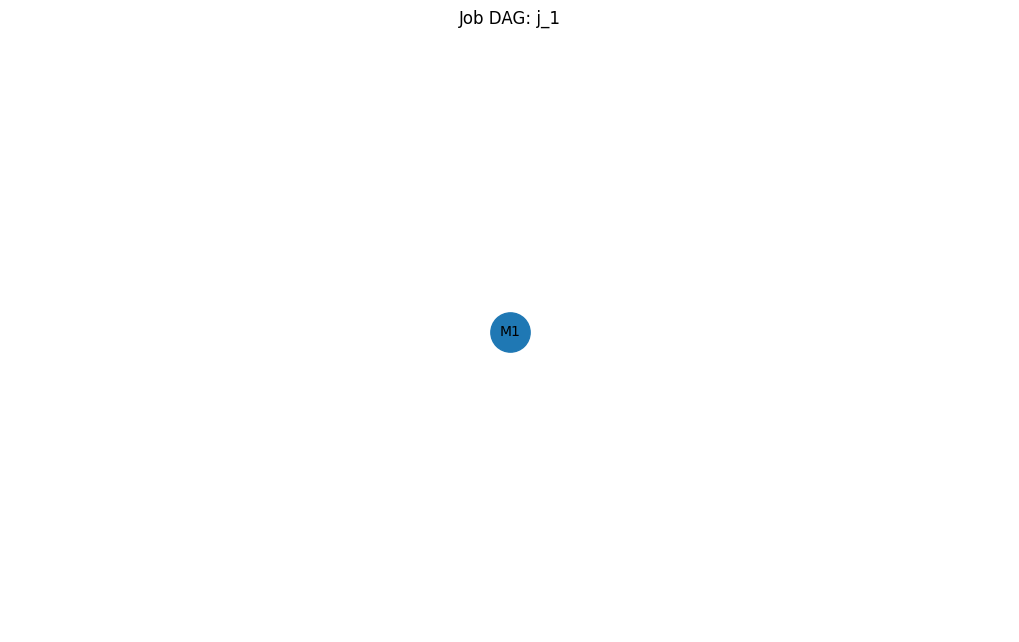

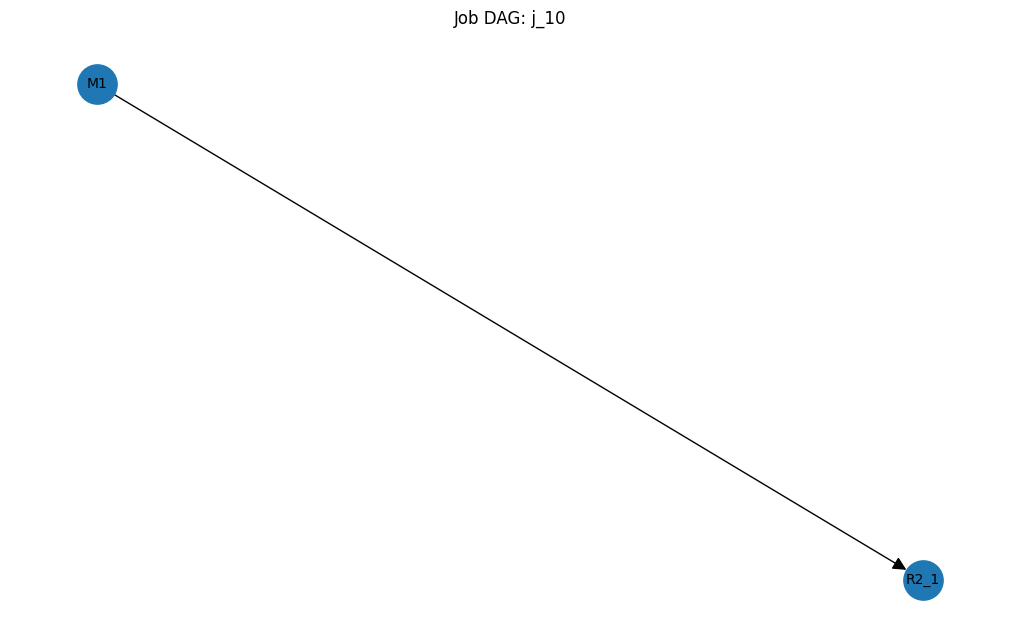

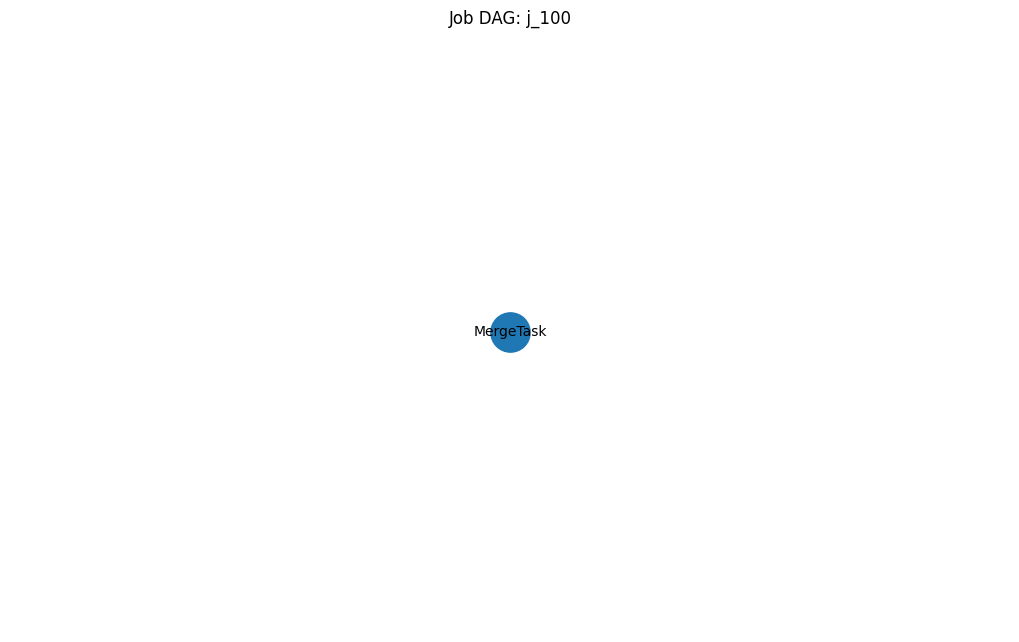

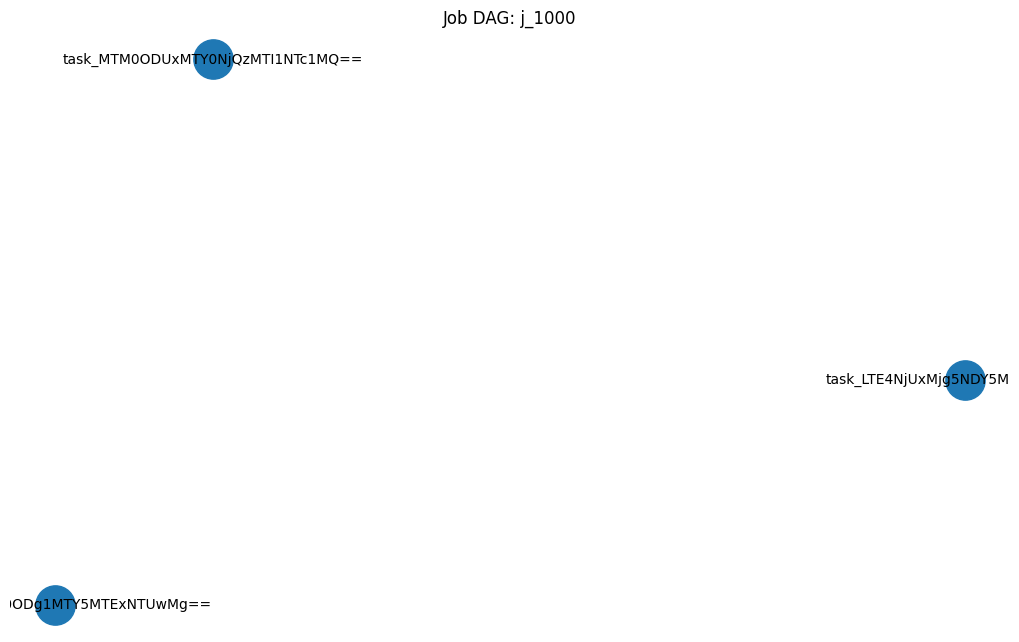

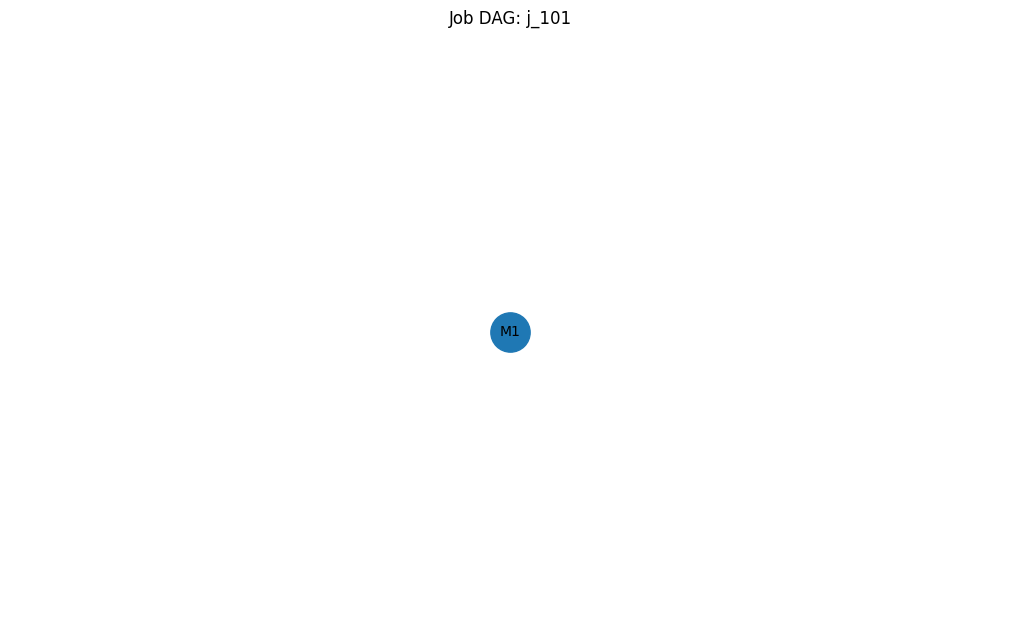

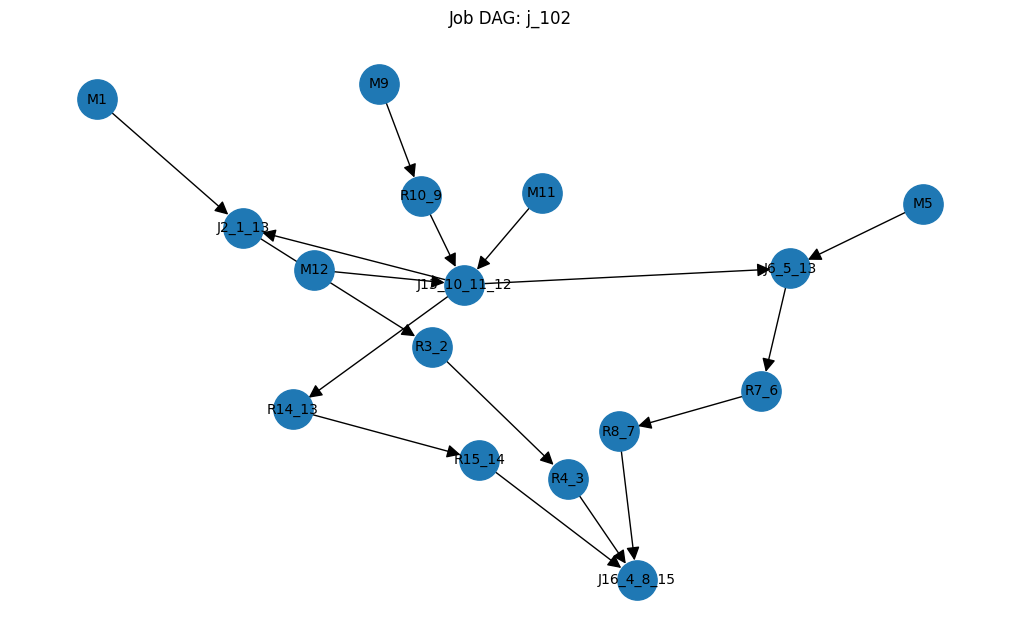

In [ ]:
def visualize_job(job_name, job, data):
    """
    job_name : string
    job      : Job object (contains list of Task objects)
    data     : PyG Data graph for that job
    """
    G = nx.DiGraph()

    task_names = [t.task_name for t in job.tasks]

    # Add nodes with readable labels
    for idx, task in enumerate(job.tasks):
        G.add_node(idx, label=task.task_name)

    # Add directed edges (parent -> child)
    for src, tgt in data.edge_index.t().tolist():
        G.add_edge(src, tgt)

    # Topological / DAG-friendly layout
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")   # Requires graphviz installed
    except:
        pos = nx.spring_layout(G, seed=42)   # fallback layout

    labels = {i: task_names[i] for i in range(len(task_names))}

    plt.figure(figsize=(10, 6))
    nx.draw(
        G, pos,
        with_labels=True,
        labels=labels,
        node_size=800,
        font_size=10,
        arrowsize=20
    )
    plt.title(f"Job DAG: {job_name}")
    plt.show()


# ---- Visualize first few jobs ----
for i, (job_name, job) in enumerate(jobs.items()):
    visualize_job(job_name, job, job_graphs[job_name])
    if i >= 5:
        break

## Implement Baseline Schedulers (FIFO & SJF)

In [ ]:
class BaseScheduler:
    def pick(
        self,
        now: float,
        ready_pairs: List[Tuple[str, str]],
        sim
    ) -> List[Tuple[str, str, int]]:
        """
        Return a prioritized list of (job_id, task_id, parallelism_limit).

        parallelism_limit (par) is how many instances of (job, task) this scheduler
        would *like* to run in the current scheduling round. The simulator will try
        up to this many, subject to remaining_instances and cluster capacity.
        """
        raise NotImplementedError


In [ ]:
class FIFOScheduler(BaseScheduler):
    def pick(self, now, ready_pairs, sim):
        ordered = sorted(
            ready_pairs,
            key=lambda p: (sim.jobs_active[p[0]].arrival_time, p[1])
        )
        result = []
        for jid, tid in ordered:
            job = sim.jobs_active[jid]
            t = sim.name_to_task[jid][tid]
            par = max(1, t.remaining_instances)
            result.append((jid, tid, par))
        return result

In [ ]:
class SJFScheduler(BaseScheduler):
    """
    SJF scheduler:
      1) Prioritize tasks from jobs with the fewest number of tasks (len(job.tasks)).
      2) Break ties by the task's total number of instances (t.num_instances).
    """
    def pick(self, now, ready_pairs, sim):
        def key_fn(pair):
            jid, tid = pair
            job = sim.jobs_active[jid]
            t = sim.name_to_task[jid][tid]

            # Primary: number of tasks in the job
            num_tasks_in_job = len(job.tasks)

            # Secondary: number of instances in this task
            task_instances = t.num_instances

            # Tertiary: task id for stable ordering
            return (num_tasks_in_job, task_instances, tid)

        ordered = sorted(ready_pairs, key=key_fn)

        result = []
        for jid, tid in ordered:
            t = sim.name_to_task[jid][tid]
            # allocate all remaining instances (at least 1)
            par = max(1, t.remaining_instances)
            result.append((jid, tid, par))

        return result

## Implement and Train GNN-only (GAT) Scheduler

In [ ]:
class GATPriority(nn.Module):
    """
    GAT backbone for scheduling.
    - Head 1: priority logits per node (for task selection).
    - Head 2: scalar parallelism value per node (non-categorical).
    """
    def __init__(self, in_dim, hid_dim: int = 64, heads: int = 4, dropout: float = 0.1):
        super().__init__()

        # GAT backbone
        self.gat1 = GATConv(in_dim, hid_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hid_dim * heads, hid_dim, heads=1, dropout=dropout)

        self.act = nn.ELU()
        self.dropout = nn.Dropout(dropout)

        # Head 1: priority score
        self.head_priority = nn.Linear(hid_dim, 1)

        # Head 2: scalar parallelism
        # This produces an unconstrained real number; we'll turn it into
        # a positive integer in the scheduler.
        self.head_par = nn.Linear(hid_dim, 1)

    def forward(self, x, edge_index, batch=None):
        # GAT backbone
        h = self.gat1(x, edge_index)
        h = self.act(h)
        h = self.dropout(h)

        h = self.gat2(h, edge_index)
        h = self.act(h)
        h = self.dropout(h)

        # Priority logits [N]
        priority_logits = self.head_priority(h).squeeze(-1)

        # Raw parallelism values [N] (real numbers)
        par_raw = self.head_par(h).squeeze(-1)

        return priority_logits, par_raw

In [ ]:
# ===== Part 2: Ready/frontier mask =====

def frontier_mask(edge_index: torch.Tensor, num_nodes: int, completed_mask: torch.Tensor = None) -> torch.Tensor:
    """
    edge_index: [2, E] with edges parent->child
    completed_mask: [N] bool tensor marking tasks already completed (optional).
                    If None, "ready" = nodes with in-degree 0.
                    If provided, "ready" = all nodes whose parents are all completed and itself not completed.

    returns: ready_mask [N] bool
    """
    device = edge_index.device
    ready = torch.zeros(num_nodes, dtype=torch.bool, device=device)

    parents_per_child = [[] for _ in range(num_nodes)]
    if edge_index.numel() > 0:
        src, tgt = edge_index
        for s, t in zip(src.tolist(), tgt.tolist()):
            parents_per_child[t].append(s)

    if completed_mask is None:
        # in-degree == 0
        for v in range(num_nodes):
            if len(parents_per_child[v]) == 0:
                ready[v] = True
    else:
        # all parents completed & node not completed
        for v in range(num_nodes):
            if not completed_mask[v]:
                p = parents_per_child[v]
                all_ok = True
                for u in p:
                    if not completed_mask[u]:
                        all_ok = False
                        break
                ready[v] = all_ok

    return ready

In [ ]:
# ===== Part 3: Training (readiness only) =====

def collate_jobs(job_graphs_dict, completed_by_job=None, batch_size=16, shuffle=True):
    """
    Yields batches of Data with fields:
      - x, edge_index, batch
      - y_ready: float labels [N] (1. for ready, 0. otherwise) computed per graph
    completed_by_job: optional dict[job_name] -> set of completed task indices (per that job)
                      If None, roots are ready.
    """
    dataset = []
    job_names = list(job_graphs_dict.keys())
    for job_name in job_names:
        data = job_graphs_dict[job_name]
        N = data.num_nodes
        # build completed boolean mask if provided
        compl = None
        if completed_by_job and job_name in completed_by_job:
            compl = torch.zeros(N, dtype=torch.bool)
            compl[list(completed_by_job[job_name])] = True

        rm = frontier_mask(data.edge_index, N, completed_mask=compl)
        data.y_ready = rm.float()  # BCE target
        dataset.append(data)

    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def train_readiness(model, loader, epochs=10, lr=1e-3, pos_weight=2.0, device='cpu'):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    # Binary Cross-Entropy loss with logits; assign higher weight to positive class (ready tasks)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    model.train()
    for ep in range(1, epochs+1):
        total_loss = 0.0
        total_nodes = 0
        for batch_data in loader:
            batch_data = batch_data.to(device)               # move batch to GPU if available
            logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
            loss = criterion(logits, batch_data.y_ready)     # compare predicted scores vs. true ready labels
            opt.zero_grad()
            loss.backward()
            opt.step()
            # accumulate weighted loss
            total_loss += loss.item() * batch_data.num_nodes
            total_nodes += batch_data.num_nodes
        avg_loss = total_loss / total_nodes
        print(f"[Epoch {ep}] Average Loss: {avg_loss:.4f}")

In [ ]:
# ===== Part 4: Global masked softmax + global inference =====

def masked_priority_probs_global(logits: torch.Tensor, ready_mask: torch.Tensor) -> torch.Tensor:
    """
    logits: [N] scores for ALL tasks (batched across jobs)
    ready_mask: [N] bool – only these can get probability mass
    returns: probs [N] in [0,1] with sum(probs) == 1 globally; probs[~ready_mask] = 0
    """
    if not ready_mask.any():
        return torch.zeros_like(logits, dtype=torch.float)
    masked = logits.clone()
    masked[~ready_mask] = -1e9  # block non-ready before softmax
    probs = torch.softmax(masked, dim=0)
    probs[~ready_mask] = 0.0
    return probs

@torch.no_grad()
def infer_priority_probs_global(model, job_graphs_subset, completed_by_job=None, device='cpu'):
    """
    Returns:
      by_job: {job_name: {task_name: prob}} with global probabilities (sum to 1 overall)
      ranked: [(job_name, task_name, prob)] sorted desc by prob
    """
    model.eval()

    job_names = list(job_graphs_subset.keys())
    data_list, ready_masks, name_lists = [], [], []

    for job_name in job_names:
        data = job_graphs_subset[job_name]
        assert hasattr(data, "task_names"), "Each Data must have .task_names aligned with node order."
        name_lists.append(data.task_names)

        N = data.num_nodes
        compl = None
        if completed_by_job and job_name in completed_by_job:
            compl = torch.zeros(N, dtype=torch.bool)
            compl[list(completed_by_job[job_name])] = True

        rm = frontier_mask(data.edge_index, N, completed_mask=compl)
        ready_masks.append(rm)
        data_list.append(Data(x=data.x, edge_index=data.edge_index))

    loader = DataLoader(data_list, batch_size=len(data_list), shuffle=False)
    batch = next(iter(loader)).to(device)
    logits, batch_vec = model(batch.x, batch.edge_index, batch.batch)  # [N], [N]

    ready_mask_cat = torch.cat([rm.to(device) for rm in ready_masks], dim=0)
    probs_all = masked_priority_probs_global(logits, ready_mask_cat)  # [N]

    by_job, ranked = {}, []
    offset = 0
    for jid, job_name in enumerate(job_names):
        n = len(name_lists[jid])
        p = probs_all[offset:offset+n].cpu()
        names = name_lists[jid]
        by_job[job_name] = {names[i]: float(p[i]) for i in range(n)}
        for i in range(n):
            if p[i] > 0:
                ranked.append((job_name, names[i], float(p[i])))
        offset += n

    ranked.sort(key=lambda x: x[2], reverse=True)
    return by_job, ranked

In [ ]:
# ===== Part 5: Training GAT =====

all_job_names = list(job_graphs.keys())
# random.shuffle(all_job_names)
subset_job_names = all_job_names[:70]
subset_job_graphs = {jn: job_graphs[jn] for jn in subset_job_names}
print("Using jobs:", subset_job_names)

# infer in_dim
tmp_dl = DataLoader([next(iter(subset_job_graphs.values()))], batch_size=1, shuffle=False)
batch0 = next(iter(tmp_dl))
in_dim = batch0.x.size(-1)
print("Inferred in_dim:", in_dim)  # should be 4

# model + loader
model = GATPriority(in_dim=in_dim)
loader = collate_jobs(subset_job_graphs, completed_by_job=None,
                         batch_size=min(16, len(subset_job_graphs)), shuffle=True)

# train (readiness supervision only)
train_readiness(model, loader, epochs=200, lr=1e-3, pos_weight=2.0, device='cpu')

# ===== Save GNN-only Model =====
os.makedirs('models', exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'in_dim': in_dim,
}, 'models/gnn_only_model.pth')
print("✓ GNN-Only model saved to models/gnn_only_model.pth")

# global inference
by_job, ranked = infer_priority_probs_global(model, subset_job_graphs, completed_by_job=None, device='cpu')

# verify global sum == 1
total_prob = sum(p for j in by_job.values() for p in j.values())
print(f"\nGlobal probability sum across all tasks: {total_prob:.6f}")

# show top-20 tasks globally
print("\nTop-20 tasks to run next (global):")
for (jn, tn, p) in ranked[:20]:
    print(f"{p: .4f}  |  {jn}  ::  {tn}")

Using jobs: ['j_1', 'j_10', 'j_100', 'j_1000', 'j_101', 'j_102', 'j_103', 'j_104', 'j_105', 'j_106', 'j_107', 'j_108', 'j_109', 'j_11', 'j_110', 'j_112', 'j_113', 'j_114', 'j_115', 'j_116', 'j_117', 'j_118', 'j_119', 'j_12', 'j_120', 'j_121', 'j_122', 'j_123', 'j_124', 'j_125', 'j_126', 'j_127', 'j_128', 'j_129', 'j_130', 'j_131', 'j_132', 'j_133', 'j_134', 'j_135', 'j_136', 'j_137', 'j_139', 'j_140', 'j_141', 'j_142', 'j_143', 'j_144', 'j_145', 'j_146', 'j_147', 'j_148', 'j_149', 'j_15', 'j_150', 'j_151', 'j_153', 'j_154', 'j_155', 'j_156', 'j_157', 'j_158', 'j_159', 'j_16', 'j_160', 'j_161', 'j_162', 'j_163', 'j_164', 'j_165']
Inferred in_dim: 9
[Epoch 1] Average Loss: 31.9106
[Epoch 2] Average Loss: 33.3146
[Epoch 3] Average Loss: 28.5197
[Epoch 4] Average Loss: 23.1609
[Epoch 5] Average Loss: 26.6035
[Epoch 6] Average Loss: 24.7308
[Epoch 7] Average Loss: 26.9600
[Epoch 8] Average Loss: 23.9925
[Epoch 9] Average Loss: 25.1101
[Epoch 10] Average Loss: 21.1107
[Epoch 11] Average Loss

In [ ]:
# ===== Part 6: Integrate GAT model into a scheduler =====
class GNNScheduler(BaseScheduler):
    """
    GNN-only scheduler that:
      (1) builds a batched PyG graph over ALL active jobs
      (2) runs model(x, edge_index) ONCE to get per-node outputs,
      (3) masks to READY nodes only,
      (4) returns an ORDERED list [(jid, tid, par), ...] of ready tasks,
          sorted by descending model priority.
    Assumes your model signature is:
        forward(x, edge_index) -> (priority_logits, par_raw)
    where:
        priority_logits: Tensor [N] or [N, K] (score_idx selects which column)
        par_raw:         Tensor [N] (arbitrary real number per node)
    """
    def __init__(self, model, device: str = "cpu", score_idx: int = 0):
        self.torch = torch
        self.model = model.to(device).eval()
        self.device = device
        self.score_idx = score_idx

    def _build_ready_batch(self, sim, ready_pairs):
        """
        Build a batched graph of all active jobs.

        Returns:
          batch_data: Data(x, edge_index) with all nodes concatenated
          flat_ready_mask: BoolTensor [total_nodes], True only for READY nodes
          node_to_pair: list[(jid, tid_name)] for each node in flat order
        """
        from torch_geometric.data import Data

        # Group ready tids per job
        by_job = {}
        for jid, tid in ready_pairs:
            by_job.setdefault(jid, set()).add(tid)

        xs = []
        eis = []
        flat_ready_mask = []
        node_to_pair = []

        node_offset = 0
        for jid, ready_tids in by_job.items():
            data = sim.job_graphs[jid]            # PyG Data for this job
            job  = sim.jobs_active[jid]
            x = data.x.to(self.device)
            ei = data.edge_index.to(self.device)

            # map task_name -> node index (assumes same order)
            name_to_idx = {t.task_name: i for i, t in enumerate(job.tasks)}

            # ready mask for this job (length N_j)
            mask_j = self.torch.zeros(x.size(0), dtype=self.torch.bool, device=self.device)
            for tid in ready_tids:
                idx = name_to_idx.get(tid, None)
                if idx is not None and 0 <= idx < x.size(0):
                    mask_j[idx] = True

            xs.append(x)
            eis.append(ei + node_offset)          # shift node indices
            flat_ready_mask.append(mask_j)

            # per-node mapping to (jid, task_name or None)
            for local_idx in range(x.size(0)):
                tid_here = None
                if local_idx < len(job.tasks):
                    tid_here = job.tasks[local_idx].task_name
                node_to_pair.append((jid, tid_here))

            node_offset += x.size(0)

        if not xs:
            return None, None, None

        X = self.torch.cat(xs, dim=0)
        EI = self.torch.cat(eis, dim=1)
        MASK = self.torch.cat(flat_ready_mask, dim=0)

        batch_data = Data(x=X, edge_index=EI)
        return batch_data, MASK, node_to_pair

    def pick(self, now, ready_pairs, sim):
        import torch.nn.functional as F

        if not ready_pairs:
            return []

        batch_data, ready_mask, node_to_pair = self._build_ready_batch(sim, ready_pairs)
        if batch_data is None:
            return []

        with self.torch.no_grad():
            raw = self.model(batch_data.x, batch_data.edge_index)

        # Expect (priority_logits, par_raw)
        if isinstance(raw, tuple) and len(raw) >= 2:
            priority_logits, par_raw = raw
        else:
            # backward compat: only scores, no parallelism head
            priority_logits = raw
            par_raw = None

        t = priority_logits
        if isinstance(t, self.torch.Tensor) and t.dim() == 2:
            t = t[:, self.score_idx]
        elif not isinstance(t, self.torch.Tensor):
            raise TypeError("Model must return a per-node Tensor or (priority, par_raw) tuple.")

        scores = t.view(-1)

        # Mask out non-ready nodes by setting them to -inf
        neg_inf = self.torch.tensor(float("-inf"), device=scores.device)
        scores = scores.clone()
        scores[~ready_mask] = neg_inf

        if self.torch.isinf(scores).all():
            return []

        # Get all node indices sorted by descending score
        sorted_indices = self.torch.argsort(scores, descending=True)

        decisions = []

        # If par_raw is provided, prepare it as [N]; else everything gets par=1
        if par_raw is not None:
            par_raw_flat = par_raw.view(-1)
        else:
            par_raw_flat = None

        for idx in sorted_indices.tolist():
            # Skip nodes that are not actually ready (score = -inf)
            if not ready_mask[idx]:
                continue

            jid, tid = node_to_pair[idx]

            # Skip nodes that do not map cleanly to a task
            if tid is None:
                continue

            # ===== Parallelism choice (non-categorical, arbitrary number) =====
            if par_raw_flat is not None:
                par_scalar = par_raw_flat[idx]
                par_value = F.softplus(par_scalar)          # > 0, real
                par = max(1, int(self.torch.round(par_value).item()))
            else:
                par = 1

            decisions.append((jid, tid, par))

        # Fallback: if mapping failed completely, revert to FIFO-ish ordering
        if not decisions:
            ordered = sorted(
                ready_pairs,
                key=lambda p: (sim.jobs_active[p[0]].arrival_time, p[1])
            )
            return [(jid, tid, 1) for (jid, tid) in ordered]

        # Return ordered list: highest-priority first
        return decisions


## Implement & Train RL-GNN Sheduler

In [ ]:
# ===== RL Scheduler =====
class RLGNNScheduler(BaseScheduler):
    """
    RL scheduler that samples actions from the policy distribution:
      - Categorical over ready tasks (via softmax on priority logits)
      - Continuous scalar for parallelism (non-categorical), modeled with a Normal distribution
    Used during training to collect trajectories.
    Assumes model forward signature:
        model(x, edge_index, batch=None) -> (priority_logits, par_raw)
    where:
        priority_logits: Tensor [N] or [N, K] (we use the first/only column)
        par_raw:         Tensor [N] (arbitrary real number per node, mean of Normal)
    At each decision it returns an ORDERED list [(jid, tid, par), ...] of ready tasks,
    with the sampled RL action first during training.
    """
    def __init__(self, model, device="cpu", temperature=1.0, training=True, par_std: float = 1.0):
        self.torch = torch
        self.model = model.to(device)
        self.device = device
        self.temperature = temperature
        self.training = training
        self.par_std = par_std  # std dev for Normal over parallelism

        if not training:
            self.model.eval()
        else:
            self.model.train()

        # Store trajectory for policy gradient
        # Each element: dict with log_prob, job/task ids, par, time, num_jobs_in_system, ...
        self.trajectory = []

    def _build_ready_batch(self, sim, ready_pairs):
        from torch_geometric.data import Data

        by_job = {}
        for jid, tid in ready_pairs:
            by_job.setdefault(jid, set()).add(tid)

        xs = []
        eis = []
        flat_ready_mask = []
        node_to_pair = []

        node_offset = 0
        for jid, ready_tids in by_job.items():
            # Build graph with current cluster state
            job = sim.jobs_active[jid]
            available_cpu = sim.total_cpu - sim.used_cpu
            available_mem = sim.total_mem - sim.used_mem

            data = sim.job_graphs[jid]
            x = data.x.to(self.device).clone()

            # Update cluster state features (last 2 features)
            if x.size(1) >= 9:  # Has cluster state features
                cpu_ratio = available_cpu / sim.total_cpu if sim.total_cpu > 0 else 1.0
                mem_ratio = available_mem / sim.total_mem if sim.total_mem > 0 else 1.0
                x[:, -2] = cpu_ratio
                x[:, -1] = mem_ratio

            ei = data.edge_index.to(self.device)
            name_to_idx = {t.task_name: i for i, t in enumerate(job.tasks)}

            mask_j = self.torch.zeros(x.size(0), dtype=self.torch.bool, device=self.device)
            for tid in ready_tids:
                idx = name_to_idx.get(tid, None)
                if idx is not None and 0 <= idx < x.size(0):
                    mask_j[idx] = True

            xs.append(x)
            eis.append(ei + node_offset)
            flat_ready_mask.append(mask_j)

            for local_idx in range(x.size(0)):
                tid_here = None
                if local_idx < len(job.tasks):
                    tid_here = job.tasks[local_idx].task_name
                node_to_pair.append((jid, tid_here))

            node_offset += x.size(0)

        if not xs:
            return None, None, None

        X = self.torch.cat(xs, dim=0)
        EI = self.torch.cat(eis, dim=1)
        MASK = self.torch.cat(flat_ready_mask, dim=0)

        batch_data = Data(x=X, edge_index=EI)
        return batch_data, MASK, node_to_pair

    def pick(self, now, ready_pairs, sim):
        import torch.nn.functional as F
        from torch.distributions import Categorical, Normal

        if not ready_pairs:
            return []

        batch_data, ready_mask, node_to_pair = self._build_ready_batch(sim, ready_pairs)
        if batch_data is None:
            return []

        # Forward pass
        if self.training:
            priority_logits, par_raw = self.model(batch_data.x, batch_data.edge_index, None)
        else:
            with self.torch.no_grad():
                priority_logits, par_raw = self.model(batch_data.x, batch_data.edge_index, None)

        # priority_logits: [N] or [N, K]; par_raw: [N] or [N, 1]
        # Make sure shapes are [N]
        if priority_logits.dim() == 2 and priority_logits.size(1) > 1:
            # if you kept a multi-head output, take first column
            priority_logits = priority_logits[:, 0]
        priority_logits = priority_logits.view(-1)

        par_raw = par_raw.view(-1)  # [N]

        logits_task = priority_logits / self.temperature

        masked_logits = logits_task.clone()
        masked_logits[~ready_mask] = float("-inf")

        # Task probabilities
        probs_task = self.torch.softmax(masked_logits, dim=0)
        probs_task = self.torch.where(ready_mask, probs_task,
                                      self.torch.zeros_like(probs_task))

        if ready_mask.sum() == 0 or probs_task.sum() <= 0:
            return []

        decisions = []

        if self.training:
            # ===== Sample ONE RL action (task + parallelism) =====
            dist_task = Categorical(probs=probs_task)
            action_idx = dist_task.sample()
            log_prob_task = dist_task.log_prob(action_idx)

            best_jid, best_tid = node_to_pair[int(action_idx.item())]

            # If sampled node does not map to a task, we will handle via fallback below
            par_sampled = None
            log_prob_par = None

            if best_tid is not None:
                # Sample parallelism (continuous, non-categorical)
                mu = par_raw[action_idx]                     # scalar
                sigma = self.par_std                         # fixed std

                dist_par = Normal(loc=mu, scale=sigma)
                z_sample = dist_par.sample()                 # real number
                log_prob_par = dist_par.log_prob(z_sample)

                # Map to positive integer parallelism
                par_value = F.softplus(z_sample)
                par = max(1, int(self.torch.round(par_value).item()))
                par_sampled = par

                # Total log_prob for this combined action
                log_prob = log_prob_task + log_prob_par

                # How many jobs are currently in the system (pending + active)
                num_jobs_in_system = len(sim.jobs_pending) + len(sim.jobs_active)

                # Store in trajectory (for Decima-style step rewards)
                self.trajectory.append({
                    'log_prob': log_prob,                           # torch scalar
                    'action_idx': int(action_idx.item()),
                    'job_id': best_jid,
                    'task_id': best_tid,
                    'par': par,
                    'par_sample': float(z_sample.item()),
                    'ready_mask': ready_mask.clone(),
                    'node_to_pair': node_to_pair,
                    'time': now,
                    'num_jobs_in_system': float(num_jobs_in_system),
                })

            # ===== Build ordered list of decisions =====
            # Sort all nodes by descending masked logits
            sorted_indices = self.torch.argsort(masked_logits, descending=True)

            # Helper: deterministic parallelism from mean for non-sampled nodes
            def deterministic_par(idx):
                mu_i = par_raw[idx]
                val = F.softplus(mu_i)
                return max(1, int(self.torch.round(val).item()))

            used = set()

            # 1) Put the sampled action first (if valid)
            if best_tid is not None:
                decisions.append((best_jid, best_tid, par_sampled))
                used.add(int(action_idx.item()))

            # 2) Append the rest of READY tasks in priority order
            for idx in sorted_indices.tolist():
                if not ready_mask[idx]:
                    continue
                if idx in used:
                    continue
                jid, tid = node_to_pair[idx]
                if tid is None:
                    continue
                par = deterministic_par(idx)
                decisions.append((jid, tid, par))

        else:
            # ===== Greedy at eval time: no sampling, just ordered list =====
            sorted_indices = self.torch.argsort(masked_logits, descending=True)

            def deterministic_par(idx):
                mu_i = par_raw[idx]
                val = F.softplus(mu_i)
                return max(1, int(self.torch.round(val).item()))

            for idx in sorted_indices.tolist():
                if not ready_mask[idx]:
                    continue
                jid, tid = node_to_pair[idx]
                if tid is None:
                    continue
                par = deterministic_par(idx)
                decisions.append((jid, tid, par))

        # Fallback if mapping failed completely
        if not decisions:
            ordered = sorted(ready_pairs,
                             key=lambda p: (sim.jobs_active[p[0]].arrival_time, p[1]))
            if not ordered:
                return []
            return [(jid, tid, 1) for (jid, tid) in ordered]

        # Return ordered list: highest-priority first (sampled RL action first in training)
        return decisions

    def clear_trajectory(self):
        """Clear stored trajectory."""
        self.trajectory = []

In [ ]:
def compute_step_reward(current_step: dict, prev_step: dict = None) -> float:
    """
    Decima-style step reward:

        r_k = - (t_k - t_{k-1}) * J_k

    where:
      - t_k = current_step['time']
      - t_{k-1} = prev_step['time'] (or 0 if None)
      - J_k = current_step['num_jobs_in_system']

    We clip dt to be non-negative to avoid numerical weirdness.
    """
    t_k = float(current_step.get('time', 0.0))

    if prev_step is None:
        return 0.0

    t_prev = float(prev_step.get('time', 0.0))
    dt = max(0.0, t_k - t_prev)

    J_k = float(current_step.get('num_jobs_in_system', 0.0))

    # More jobs and longer intervals => more negative reward
    return -dt * J_k

In [ ]:
def train_rl_policy(
    model,
    jobs: Dict[str, Job],
    num_episodes: int = 200,
    lr: float = 5e-5,
    baseline_decay: float = 0.9,
    gamma: float = 1.0,
    device: str = 'cpu',
    M: int = 10,
    cpu: float = 96.0,
    mem: float = 100.0,
    seed: int = None,
    entropy_coef: float = 0.0,
    max_grad_norm: float = 1.0,
):
    """
    Train policy using Decima-style step rewards and stabilized REINFORCE.

    Changes vs your previous version:
      - Uses Decima step rewards r_k = -Δt * (#jobs_in_system)
      - Uses a global running baseline over episode returns
      - Normalizes and clips advantages
      - Clips gradients
      - Temperature annealing from 1.5 -> 0.5
    """

    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Running baseline over episode returns
    baseline_return = None
    episode_returns: List[float] = []
    episode_jcts: List[float] = []

    best_avg_jct = float('inf')
    best_model_state = None

    # Simple temperature schedule for exploration
    temp_start, temp_end = 1.5, 0.5

    job_items = list(jobs.items())

    for episode in range(num_episodes):
        # --- Seeding for reproducibility ---
        if seed is not None:
            torch.manual_seed(seed + episode)
            np.random.seed(seed + episode)

        # Small reshuffle of job order each episode
        np.random.shuffle(job_items)

        # Clone jobs for this episode
        cloned_jobs: Dict[str, Job] = {}
        for jid, job in job_items:
            ts = [
                Task(
                    t.task_name,
                    t.num_instances,
                    t.task_type,
                    t.cpu,
                    t.mem,
                    list(t.instance_running_time),
                    list(t.parents),
                )
                for t in job.tasks
            ]
            cloned_jobs[jid] = Job(job.job_name, job.arrival_time, ts)

        # --- Temperature annealing ---
        frac = episode / max(1, num_episodes - 1)
        current_temp = temp_start + (temp_end - temp_start) * frac

        # RL scheduler in training mode
        rl_scheduler = RLGNNScheduler(
            model=model,
            device=device,
            training=True,
            temperature=current_temp,
        )
        rl_scheduler.clear_trajectory()

        # Simulator
        sim = ClusterSim(machines=build_machines(M, cpu, mem), scheduler=rl_scheduler)
        sim.add_jobs(cloned_jobs)

        # Run the episode (fills rl_scheduler.trajectory)
        job_completion_times = sim.run()

        # --- Logging: avg JCT for this episode ---
        if job_completion_times:
            avg_jct = float(np.mean(list(job_completion_times.values())))
        else:
            avg_jct = float('inf')
        episode_jcts.append(avg_jct)

        # --- Build returns from trajectory ---
        traj = rl_scheduler.trajectory
        if not traj:
            # No actions taken (should be rare, but be robust)
            episode_returns.append(0.0)
            continue

        log_probs = []
        rewards = []
        prev_step = None

        for step in traj:
            log_probs.append(step['log_prob'])  # torch scalar on device
            r = compute_step_reward(step, prev_step)
            rewards.append(r)
            prev_step = step

        log_probs = torch.stack(log_probs)  # [T]
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)  # [T]

        # Discounted returns G_t = sum_{k>=t} gamma^{k-t} r_k
        returns = torch.zeros_like(rewards)
        G = 0.0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + gamma * G
            returns[t] = G

        episode_return = returns.mean().item()
        episode_returns.append(episode_return)

        # --- Running baseline over episode returns ---
        if baseline_return is None:
            baseline_return = episode_return
        else:
            baseline_return = baseline_decay * baseline_return + (1.0 - baseline_decay) * episode_return

        # Advantages: A_t = G_t - baseline_return
        advantages = returns - baseline_return

        # Normalize and clip advantages to reduce variance & explosions
        adv_mean = advantages.mean()
        adv_std = advantages.std()
        if adv_std > 1e-6:
            advantages = (advantages - adv_mean) / (adv_std + 1e-8)
        advantages = advantages.clamp(-5.0, 5.0)

        # Policy gradient loss
        policy_loss = -(log_probs * advantages.detach()).sum()

        # Optional entropy regularization (disabled by default)
        loss = policy_loss

        optimizer.zero_grad()
        loss.backward()
        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        # --- Track best model based on recent JCT ---
        recent = [j for j in episode_jcts[-10:] if j != float('inf')]
        recent_avg = float(np.mean(recent)) if recent else float('inf')
        if recent and recent_avg < best_avg_jct:
            best_avg_jct = recent_avg
            best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        # --- Progress logging ---
        if (episode + 1) % 5 == 0 or episode == 0:
            print(
                f"Episode {episode + 1}/{num_episodes} | "
                f"Recent Avg JCT(10): {recent_avg:.2f} | "
                f"Best Avg JCT(10): {best_avg_jct:.2f} | "
                f"Return: {episode_return:.2f} | "
                f"Baseline: {baseline_return:.2f} | "
                f"Temp: {current_temp:.2f}"
            )

    # Restore best model w.r.t. moving-average JCT
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Restored best model (avg JCT over last-10 window: {best_avg_jct:.2f})")

    return {
        'episode_returns': episode_returns,
        'episode_jcts': episode_jcts,
        'final_baseline_return': baseline_return,
        'best_avg_jct': best_avg_jct,
    }

In [ ]:
# ===== RL Training =====
# Update the model to handle the new input dimension
# Original: num_instances, cpu, mem, task_type, remaining_work, arrival_time, job_task_num
# New: + cpu_available_ratio, mem_available_ratio

# Get a subset of jobs for training
train_jobs = dict(list(jobs.items())[:50])

# Infer input dimension from updated graph
sample_job_name = list(train_jobs.keys())[0]
sample_graph = build_job_graphs_with_cluster_state(
    {sample_job_name: train_jobs[sample_job_name]},
    available_cpu=960.0,   # 10 machines * 96 CPU
    available_mem=1000.0,  # 10 machines * 100 mem
    total_cpu=960.0,
    total_mem=1000.0
)
in_dim = sample_graph[sample_job_name].x.size(1)
print(f"Input dimension (with cluster state): {in_dim}")

# Create model with updated input dimension
rl_model = GATPriority(in_dim=in_dim, hid_dim=64, heads=4, dropout=0.1)

# No more per-job baselines – Decima reward is global and step-based
if hasattr(train_rl_policy, 'job_baselines'):
    delattr(train_rl_policy, 'job_baselines')

# Train RL policy with Decima's reward formulation
print("Starting RL training with Decima-style flow-time reward...")
training_stats = train_rl_policy(
    model=rl_model,
    jobs=train_jobs,
    num_episodes=150,   # More episodes for better learning
    lr=5e-5,            # Slightly lower learning rate for stability
    baseline_decay=0.95,
    gamma=1.0,          # Decima-style: time is in the reward, so no extra discounting
    device="cuda" if torch.cuda.is_available() else "cpu",
    M=20,
    cpu=96.0,
    mem=100.0,
    seed=42
)

print("\nTraining completed!")
print(f"Final baseline return: {training_stats['final_baseline_return']:.2f}")
print(f"Best 10-episode avg JCT: {training_stats['best_avg_jct']:.2f}")

# ===== Save RL Model =====
os.makedirs('models', exist_ok=True)
torch.save({
    'model_state_dict': rl_model.state_dict(),
    'in_dim': in_dim,
    'hid_dim': 64,
    'out_dim': 1,
    'heads': 4,
    'dropout': 0.1,
    'training_stats': training_stats
}, 'models/rl_model.pth')
print("✓ RL model saved to models/rl_model.pth")

Input dimension (with cluster state): 9
Starting RL training with Decima-style flow-time reward...


KeyboardInterrupt: 

In [ ]:
# ===== Visualize Training Progress =====

def _moving_average(arr, window):
    """Return moving average (valid mode). Handles edge cases."""
    window = int(max(1, window))
    if len(arr) < window:
        return np.array([]), np.array([])
    ma = np.convolve(arr, np.ones(window) / window, mode='valid')
    xs = np.arange(window - 1, len(arr))
    return xs, ma

def plot_training_progress(training_stats):
    """Plot training curves for JCT and rewards (robust to missing keys)."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- Avg JCT per episode ---
    raw_jcts = training_stats.get('episode_jcts', [])
    # filter out infinities used when sim failed/returned nothing
    jcts = [float(j) for j in raw_jcts if (isinstance(j, (int, float)) and not np.isinf(j))]
    if len(jcts) == 0:
        ax1.text(0.5, 0.5, "No JCT data available", ha='center', va='center')
    else:
        ax1.plot(range(len(jcts)), jcts, label='Avg JCT per Episode', alpha=0.7)
        if len(jcts) > 3:
            window = min(10, max(2, len(jcts) // 5))
            xs, moving_avg = _moving_average(jcts, window)
            if moving_avg.size:
                ax1.plot(xs, moving_avg, label=f'Moving Avg (w={window})', linewidth=2)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Job Completion Time')
    ax1.set_title('Training: Job Completion Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Rewards / Returns ---
    # Backwards-compat: some runs store 'episode_rewards', newer code stored 'episode_returns'
    if 'episode_returns' in training_stats:
        raw_rewards = training_stats['episode_returns']
        rewards_label = 'episode_returns'
        reward_desc = 'Episode Return'
    else:
        raw_rewards = []
        reward_desc = 'Rewards/Returns (none)'

    rewards = [float(r) for r in raw_rewards if isinstance(r, (int, float)) and not np.isnan(r)]
    if len(rewards) == 0:
        ax2.text(0.5, 0.5, "No reward/return data available", ha='center', va='center')
    else:
        ax2.plot(range(len(rewards)), rewards, label=reward_desc, alpha=0.7)
        if len(rewards) > 3:
            window = min(10, max(2, len(rewards) // 5))
            xs, moving_avg = _moving_average(rewards, window)
            if moving_avg.size:
                ax2.plot(xs, moving_avg, label=f'Moving Avg (w={window})', linewidth=2)

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Return')
    ax2.set_title('Training: Returns')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training progress if training_stats exists in this scope
training_stats  # reference to see if variable exists
plot_training_progress(training_stats)

## Evaluate

In [ ]:
# ===== Evaluate trained RL model =====
def evaluate(model=None, jobs=None, M=10, cpu=96.0, mem=100.0, seed=123,
             rlgnn_model_path='models/rl_model.pth',
             gnn_model_path='models/gnn_only_model.pth'):
    """Evaluate trained RL model against baselines and collect per-job stats."""

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load RL model if not provided
    if model is None:
        if os.path.exists(rlgnn_model_path):
            checkpoint = torch.load(rlgnn_model_path, map_location=device, weights_only=False)

            model = GATPriority(
                in_dim=checkpoint['in_dim'],
                hid_dim=checkpoint.get('hid_dim', 64),
                heads=checkpoint.get('heads', 4),
                dropout=checkpoint.get('dropout', 0.1),
            )
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            model = model.to(device)
            print(f"✓ Loaded RL model from {rlgnn_model_path}")
            print(f"  Model architecture: in_dim={checkpoint['in_dim']}, "
                  f"hid_dim={checkpoint.get('hid_dim', 64)}, "
                  f"heads={checkpoint.get('heads', 4)}, "
                  f"dropout={checkpoint.get('dropout', 0.1)}")
        else:
            raise FileNotFoundError(
                f"RL model not found at {rlgnn_model_path}. Please train the model first."
            )
    else:
        model = model.to(device)

    # Load GNN-only model (used by GNNScheduler)
    gnn_model = None
    if os.path.exists(gnn_model_path):
        checkpoint = torch.load(gnn_model_path, map_location=device, weights_only=False)

        gnn_model = GATPriority(
            in_dim=checkpoint['in_dim'],
            hid_dim=checkpoint.get('hid_dim', 64),
            heads=checkpoint.get('heads', 4),
            dropout=checkpoint.get('dropout', 0.1),
        )
        gnn_model.load_state_dict(checkpoint['model_state_dict'])
        gnn_model = gnn_model.to(device)
        gnn_model.eval()
        print(f"✓ Loaded GNN-only model from {gnn_model_path}")
    else:
        print(f"⚠ Warning: GNN-only model not found at {gnn_model_path}. "
              f"Skipping GNN-only evaluation.")

    results = []
    metrics_by_scheduler = {}      # time-series metrics
    job_stats_by_scheduler = {}    # per-job stats for plots

    schedulers = [
        ("FIFO", FIFOScheduler()),
        ("SJF", SJFScheduler()),
    ]

    # Add GNN-only if model is available
    if gnn_model is not None:
        schedulers.append((
            "GNN-only",
            GNNScheduler(model=gnn_model, device=device, score_idx=0)
        ))

    # Add RL-GNN (eval mode; training=False => greedy policy)
    model.eval()
    schedulers.append((
        "RL-GNN",
        RLGNNScheduler(model=model, device=device, training=False, temperature=0.5)
    ))

    for name, sched in schedulers:
        # Clone jobs (so each scheduler sees the same workload)
        cloned = {}
        for jid, job in jobs.items():
            ts = [
                Task(
                    t.task_name,
                    t.num_instances,
                    t.task_type,
                    t.cpu,
                    t.mem,
                    list(t.instance_running_time),
                    list(t.parents),
                )
                for t in job.tasks
            ]
            cloned[jid] = Job(job.job_name, job.arrival_time, ts)

        sim = ClusterSim(machines=build_machines(M, cpu, mem), scheduler=sched)
        sim.add_jobs(cloned)

        # jct maps job_id -> JCT (completion - arrival)
        jct = sim.run()

        # Capture metrics history for this scheduler (for utilization / queue plots)
        metrics_by_scheduler[name] = sim.metrics_history

        # Per-job stats
        job_stats = []
        for jid, jct_val in jct.items():
            job = cloned[jid]
            arrival_time = float(job.arrival_time)

            jct_val = float(jct_val)
            completion_time = arrival_time + jct_val  # wall-clock completion if needed

            num_tasks = len(job.tasks)
            total_instances = sum(t.num_instances for t in job.tasks)

            job_stats.append({
                "job_id": jid,
                "arrival_time": arrival_time,
                "completion_time": completion_time,
                "jct": jct_val,
                "job_size_tasks": int(num_tasks),
                "job_size_instances": int(total_instances),
            })

        job_stats_by_scheduler[name] = job_stats

        avg = float(np.mean(list(jct.values()))) if jct else float('nan')
        results.append({
            "scheduler": name,
            "avg_job_completion_time": avg,
            "num_jobs": len(jct)
        })

        print(f"{name}: Avg JCT = {avg:.2f}")

    results_df = pd.DataFrame(results).sort_values(by="avg_job_completion_time")

    # Return results, time-series metrics, and per-job stats
    return results_df, metrics_by_scheduler, job_stats_by_scheduler


test_jobs = dict(list(jobs.items())[700:800])  # Use different subset for testing
print("Evaluating trained RL model...")
eval_results, metrics_by_scheduler, job_stats_by_scheduler = evaluate(
    model=None,
    jobs=test_jobs,
    M=10,
    cpu=96.0,
    mem=100.0,
    seed=123,
)
print("\nEvaluation Results:")
print(eval_results)


Evaluating trained RL model...
✓ Loaded RL model from models/rl_model.pth
  Model architecture: in_dim=9, hid_dim=64, heads=4, dropout=0.1
✓ Loaded GNN-only model from models/gnn_only_model.pth
FIFO: Avg JCT = 74290.29
SJF: Avg JCT = 29608.82
GNN-only: Avg JCT = 79235.79
RL-GNN: Avg JCT = 7178.42

Evaluation Results:
  scheduler  avg_job_completion_time  num_jobs
3    RL-GNN              7178.418367        98
1       SJF             29608.816327        98
0      FIFO             74290.285714        98
2  GNN-only             79235.785714        98


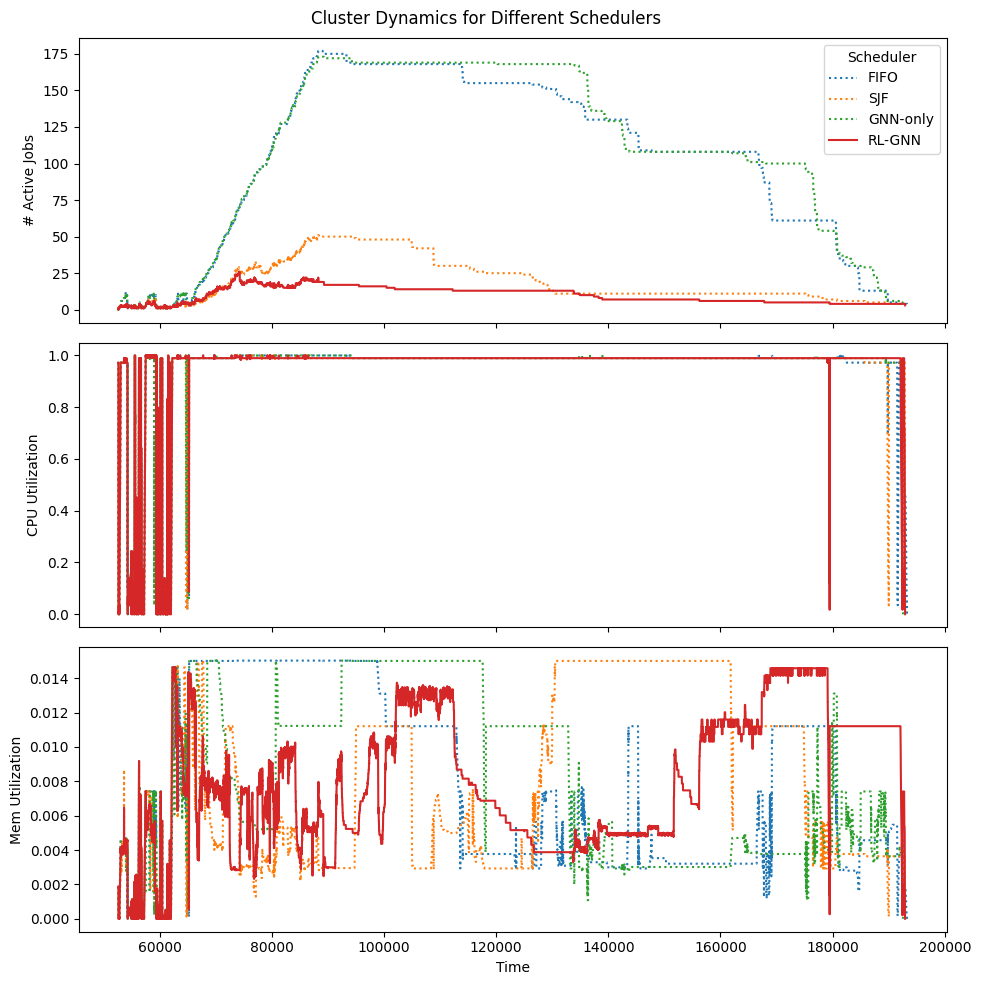

In [ ]:
def plot_scheduler_metrics(metrics_by_scheduler, total_cpu, total_mem):
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    ax_jobs, ax_cpu, ax_mem = axes

    # Define which scheduler gets solid line
    HIGHLIGHT_SCHEDULER = "RL-GNN"

    for name, history in metrics_by_scheduler.items():
        if not history:
            continue

        # Choose line style
        linestyle = "-" if name == HIGHLIGHT_SCHEDULER else ":"

        times = [m["time"] for m in history]
        num_jobs = [m["num_active_jobs"] for m in history]
        used_cpu = [m["used_cpu"] for m in history]
        used_mem = [m["used_mem"] for m in history]

        cpu_util = [u / total_cpu if total_cpu > 0 else 0.0 for u in used_cpu]
        mem_util = [u / total_mem if total_mem > 0 else 0.0 for u in used_mem]

        # Active jobs
        ax_jobs.plot(times, num_jobs, label=name, linestyle=linestyle)

        # CPU utilization
        ax_cpu.plot(times, cpu_util, label=name, linestyle=linestyle)

        # Memory utilization
        ax_mem.plot(times, mem_util, label=name, linestyle=linestyle)

    # Axis labels
    ax_jobs.set_ylabel("# Active Jobs")
    ax_cpu.set_ylabel("CPU Utilization")
    ax_mem.set_ylabel("Mem Utilization")
    ax_mem.set_xlabel("Time")

    # Legend (single legend is enough)
    ax_jobs.legend(title="Scheduler")

    fig.suptitle("Cluster Dynamics for Different Schedulers")
    plt.tight_layout()
    plt.show()


# ===== Usage =====
M = 30
cpu_per_machine = 96.0
mem_per_machine = 100.0

total_cpu = M * cpu_per_machine
total_mem = M * mem_per_machine

plot_scheduler_metrics(metrics_by_scheduler, total_cpu, total_mem)


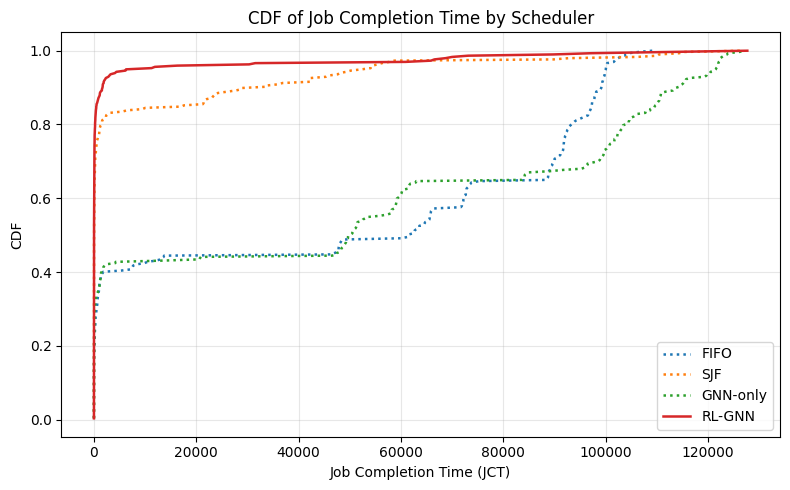

In [ ]:
def plot_jct_cdf(job_stats_by_scheduler):
    plt.figure(figsize=(8, 5))

    for name, job_stats in job_stats_by_scheduler.items():
        if not job_stats:
            continue

        jcts = np.array([js["jct"] for js in job_stats], dtype=float)

        jcts_sorted = np.sort(jcts)
        y = np.arange(1, len(jcts_sorted) + 1) / len(jcts_sorted)

        linestyle = "-" if name == "RL-GNN" else ":"

        plt.plot(
            jcts_sorted,
            y,
            linestyle=linestyle,
            linewidth= 1.8,
            label=name
        )

    plt.xlabel("Job Completion Time (JCT)")
    plt.ylabel("CDF")
    plt.title("CDF of Job Completion Time by Scheduler")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_jct_cdf(job_stats_by_scheduler)


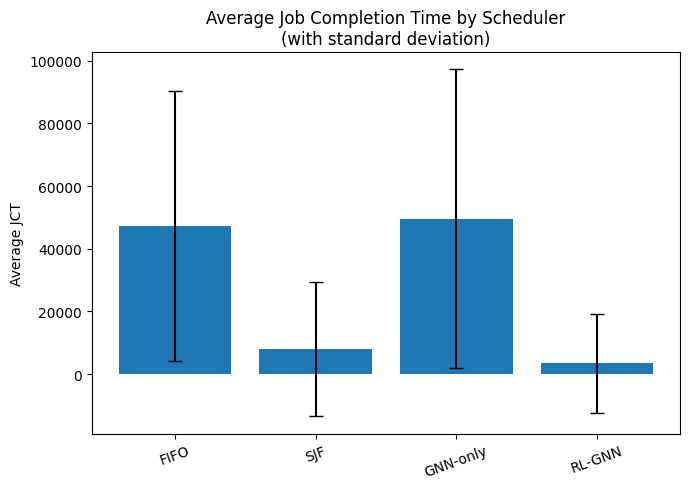

In [ ]:
def plot_mean_jct_with_error(job_stats_by_scheduler):
    names = []
    means = []
    stds = []

    for name, job_stats in job_stats_by_scheduler.items():
        if not job_stats:
            continue

        jcts = np.array([js["jct"] for js in job_stats], dtype=float)
        names.append(name)
        means.append(jcts.mean())
        stds.append(jcts.std())

    x = np.arange(len(names))

    plt.figure(figsize=(7, 5))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, names, rotation=20)
    plt.ylabel("Average JCT")
    plt.title("Average Job Completion Time by Scheduler\n(with standard deviation)")
    plt.tight_layout()
    plt.show()

plot_mean_jct_with_error(job_stats_by_scheduler)

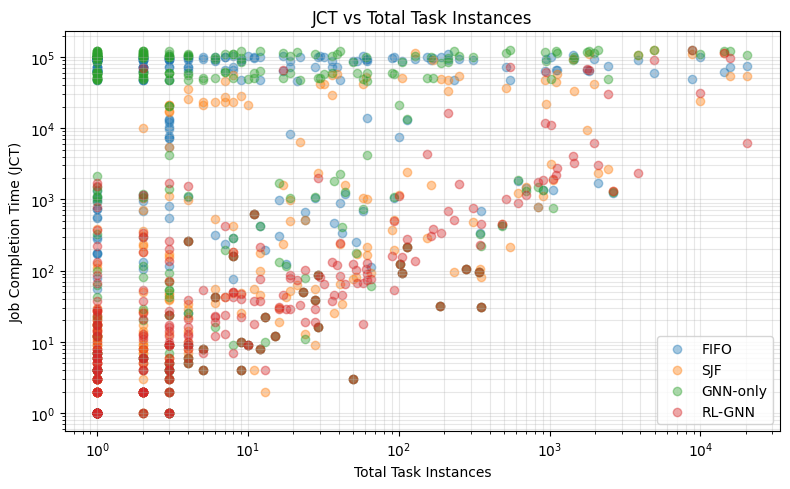

In [ ]:
def plot_jct_vs_job_size(job_stats_by_scheduler, log_scale=True):
    """
    X-axis: Total number of task instances per job
    Y-axis: Job Completion Time (JCT)
    """

    plt.figure(figsize=(8, 5))

    for name, job_stats in job_stats_by_scheduler.items():
        if not job_stats:
            continue

        sizes = np.array(
            [js["job_size_instances"] for js in job_stats],
            dtype=float
        )
        jcts = np.array(
            [js["jct"] for js in job_stats],
            dtype=float
        )

        plt.scatter(sizes, jcts, alpha=0.4, label=name)

    plt.xlabel("Total Task Instances")
    plt.ylabel("Job Completion Time (JCT)")

    if log_scale:
        plt.xscale("log")
        plt.yscale("log")

    plt.grid(True, which="both", alpha=0.3)
    plt.title("JCT vs Total Task Instances")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_jct_vs_job_size(job_stats_by_scheduler, log_scale=True)
